## Learning Young's modulus (m) to displacement (u) map for Linear Elasticity problem (Implementation 1)

Data is located in `../data` directory, and key data of our interest is in `LinearElasticity_samples.npz` file. We would also need the mesh data in files with names `LinearElasticity_m_mesh` and `LinearElasticity_u_mesh` for plotting.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement2/neural_operator_prediction_comparison.png" width="800"> </p>

In [1]:
import sys
import os
import time

import torch
import numpy as np

import dolfin as dl

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics
from dataMethods import DataProcessor
from torch_deeponet import DeepONet

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement2/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [3]:
num_train = 1900
num_test = 100

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_Y_components = 2 # displacement field in 2D
num_tr_outputs = 100 # number of outputs from the trunk network before they are multiplied
num_br_outputs = num_Y_components * num_tr_outputs # 100 for u1 and 100 for u2
out_coordinate_dimension = 2 # domain for output function is 2D

# training hyperparameters
batch_size = 100
epochs = 1000
lr = 1.0e-3
act_fn = torch.relu

data_prefix = 'LinearElasticity'
data = DataProcessor(data_folder + data_prefix + '_samples.npz', num_train, num_test, num_inp_fn_points, num_out_fn_points, num_Y_components)

train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

X_train: (1900, 2601)
Y_train: (1900, 5202)
X_test: (100, 2601)
Y_test: (100, 5202)
X_trunk: (2601, 2)


## Create model and train the network

In [4]:
num_layers = 4
num_neurons = 128
model = DeepONet(num_layers, num_neurons, act_fn, num_br_outputs, num_tr_outputs, num_inp_fn_points, out_coordinate_dimension, num_Y_components)

In [5]:
# Train
model.train(train_data, test_data, batch_size=batch_size, epochs = epochs, lr = lr)

Epoch:     0, Train Loss (l2 squared): 9.840e-01, Test Loss (l2 squared): 9.182e-01, Time (sec): 0.296
Epoch:   100, Train Loss (l2 squared): 1.357e-01, Test Loss (l2 squared): 1.330e-01, Time (sec): 0.285
Epoch:   200, Train Loss (l2 squared): 7.931e-02, Test Loss (l2 squared): 7.663e-02, Time (sec): 0.238
Epoch:   300, Train Loss (l2 squared): 6.688e-02, Test Loss (l2 squared): 6.500e-02, Time (sec): 0.245
Epoch:   400, Train Loss (l2 squared): 7.437e-02, Test Loss (l2 squared): 7.205e-02, Time (sec): 0.234
Epoch:   500, Train Loss (l2 squared): 3.935e-02, Test Loss (l2 squared): 3.824e-02, Time (sec): 0.246
Epoch:   600, Train Loss (l2 squared): 2.845e-02, Test Loss (l2 squared): 2.769e-02, Time (sec): 0.247
Epoch:   700, Train Loss (l2 squared): 2.562e-02, Test Loss (l2 squared): 2.469e-02, Time (sec): 0.233
Epoch:   800, Train Loss (l2 squared): 2.935e-02, Test Loss (l2 squared): 2.869e-02, Time (sec): 0.245
Epoch:   900, Train Loss (l2 squared): 2.383e-02, Test Loss (l2 squared):

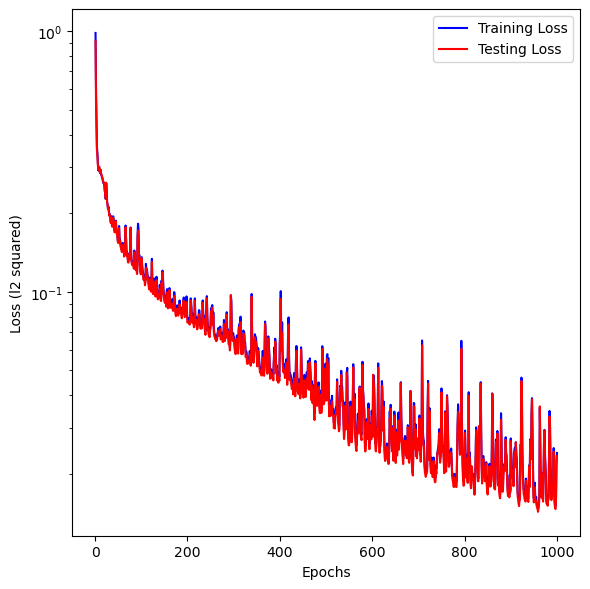

In [6]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

## Test and plot the output of network

In [7]:
Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 5202), test_pred shape: (100, 5202)
Num tests:   100, Mean Loss (rel l2): 1.755e-01, Std Loss (rel l2): 7.286e-02


In [8]:
def get_FE_space(mesh_file = data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector = False):
    mesh = dl.Mesh()
    with dl.XDMFFile(mesh_file) as infile:
        infile.read(mesh)
    if is_vector:
        V = dl.VectorFunctionSpace(mesh, "Lagrange", 1)
    else:
        V = dl.FunctionSpace(mesh, "Lagrange", 1)
    return V

In [9]:
Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
i_pred = Y_test_pred[0, :]
u_fn = dl.Function(Vu)
u_vec = u_fn.vector().get_local()
print('u_vec shape: {}, i_pred shape: {}'.format(u_vec.shape, i_pred.shape))

u_vec shape: (5202,), i_pred shape: (5202,)


i_plot =    26, error (rel l2): 7.219e-03
i_plot =    86, error (rel l2): 8.981e-03
i_plot =     2, error (rel l2): 3.904e-03
i_plot =    55, error (rel l2): 4.730e-03
i_plot =    75, error (rel l2): 2.741e-03
i_plot =    93, error (rel l2): 7.447e-03
i_plot =    16, error (rel l2): 4.115e-03
i_plot =    73, error (rel l2): 7.825e-03
i_plot =    54, error (rel l2): 1.128e-02
i_plot =    95, error (rel l2): 4.809e-03
i_plot =    53, error (rel l2): 1.191e-02
i_plot =    92, error (rel l2): 3.562e-03
i_plot =    78, error (rel l2): 4.072e-03
i_plot =    13, error (rel l2): 5.435e-03
i_plot =     7, error (rel l2): 1.012e-02
i_plot =    30, error (rel l2): 1.958e-02


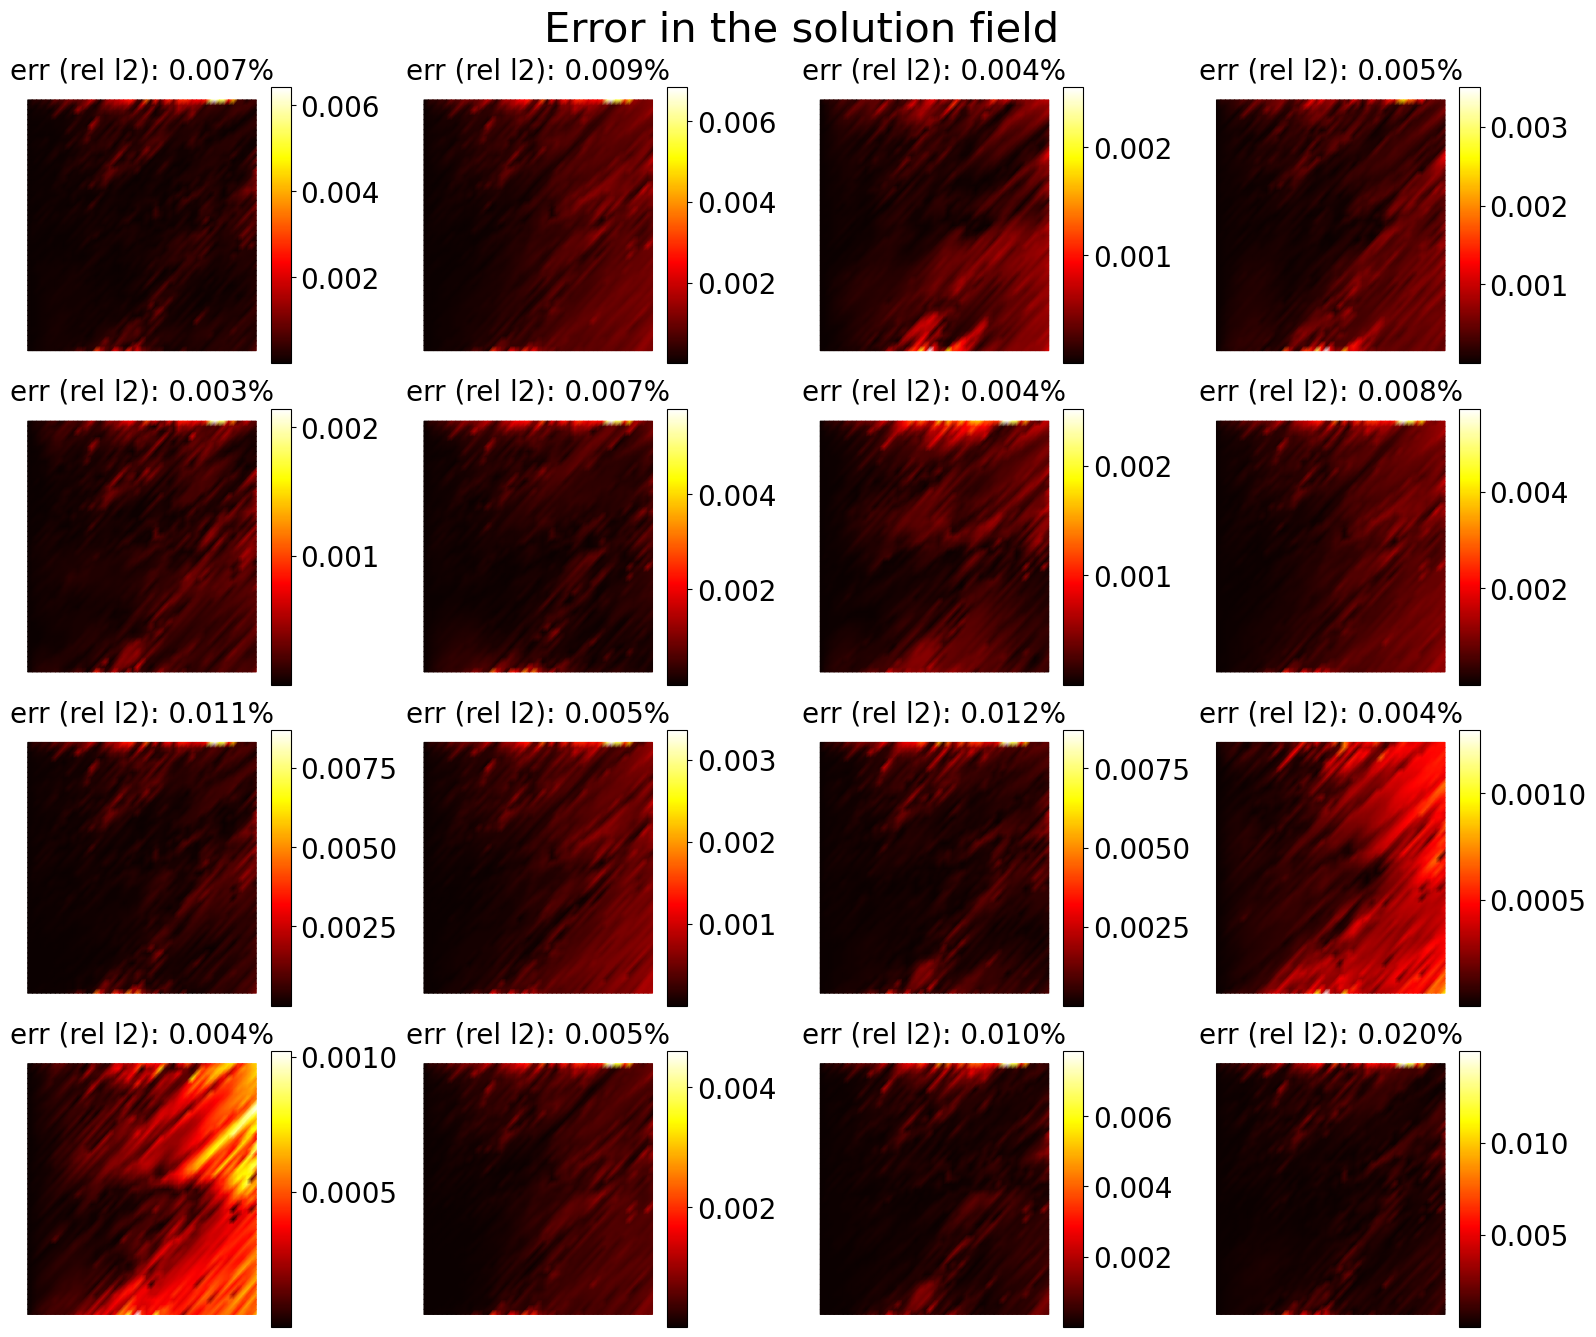

In [10]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + data_prefix + '_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + data_prefix + '_m_mesh.xdmf')

Y_spatial_points = data.X_trunk

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows*cols, replace=False)

for i in range(rows):
    for j in range(cols):
        i_plot = i_choices[i*cols + j]

        i_pred = Y_test_pred[i_plot]
        i_truth = Y_test[i_plot]
        if decode:
            i_pred = data.decoder_Y(i_pred)
            i_truth = data.decoder_Y(i_truth)

        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = Y_spatial_points

        cbar = field_plot_fenics(axs[i,j], i_diff.flatten(), \
                                     Vu, \
                                     cmap = 'hot', \
                                     add_displacement_to_nodes = False, \
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
        axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()


i_plot =    18, error (rel l2): 7.185e-03
i_plot =    29, error (rel l2): 3.837e-03
i_plot =    64, error (rel l2): 3.637e-03
i_plot =    92, error (rel l2): 3.562e-03


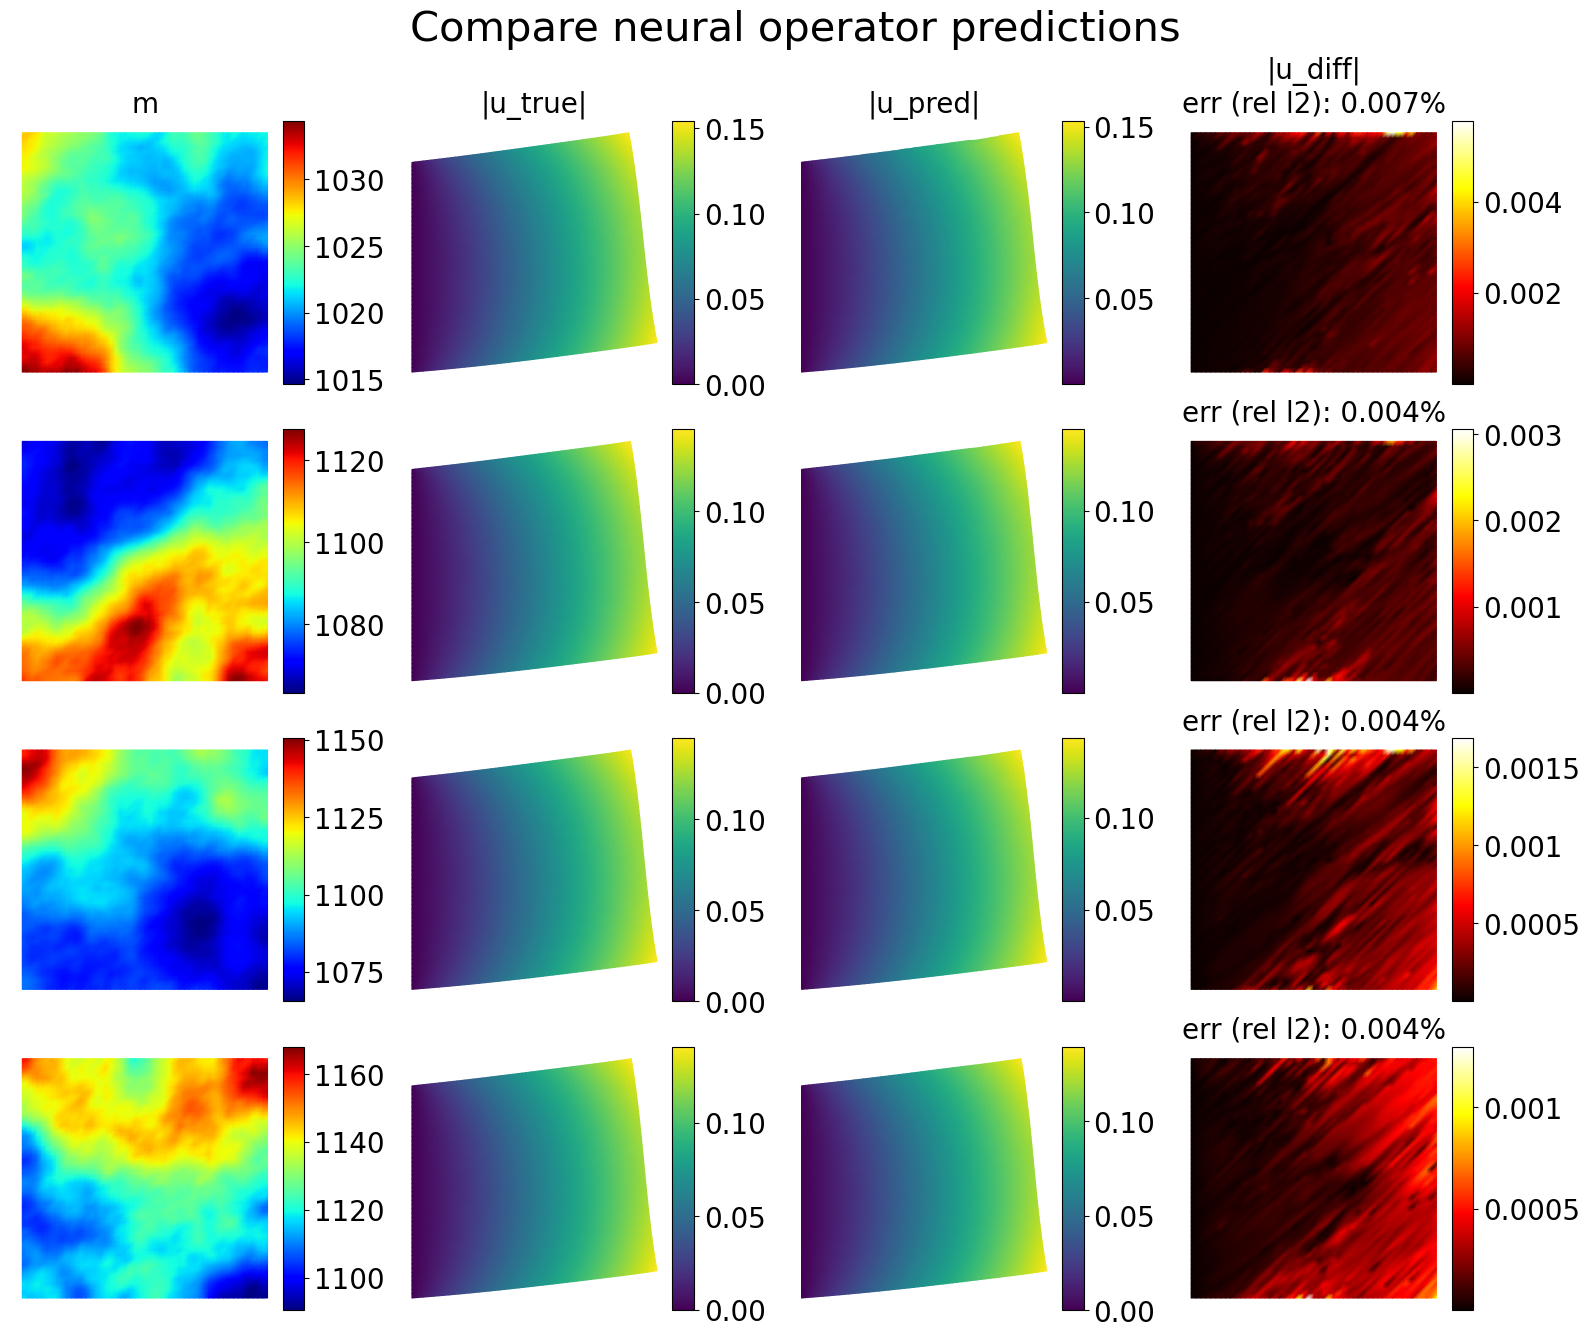

In [11]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + data_prefix + '_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + data_prefix + '_m_mesh.xdmf')

# row: m, u_true, u_pred, u_diff
u_tags = ['m', '|u_true|', '|u_pred|', '|u_diff|']
cmaps = ['jet', 'viridis', 'viridis', 'hot']
Vvec = [Vm, Vu, Vu, Vu]
Y_spatial_points = data.X_trunk # for this problem, nodes are same for m and u functions
X_spatial_points = Y_spatial_points

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        nodes = Y_spatial_points if j > 0 else X_spatial_points
        
        if j == 0:
            cbar = field_plot_fenics(axs[i,j], uvec[j], Vvec[j], cmap = cmaps
            [j])
        elif j == cols - 1:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = False,\
                                     is_displacement = True)
        else:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = True,\
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()
